In [10]:
import pandas as pd #panda library
import csv #for CSV file
import urllib.request as urllib2 # to link the .CSV file via URL.
import numpy as np
from sklearn.model_selection import train_test_split
import time

start_time = time.time()

url = 'https://raw.githubusercontent.com/ageron/handson-ml/master/datasets/housing/housing.csv'
response = urllib2.urlopen(url)

dataset = pd.read_csv(response)
dataset = dataset.dropna()
dataset.head(10) #gives first 10 result 

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY
5,-122.25,37.85,52.0,919.0,213.0,413.0,193.0,4.0368,269700.0,NEAR BAY
6,-122.25,37.84,52.0,2535.0,489.0,1094.0,514.0,3.6591,299200.0,NEAR BAY
7,-122.25,37.84,52.0,3104.0,687.0,1157.0,647.0,3.1200,241400.0,NEAR BAY
8,-122.26,37.84,42.0,2555.0,665.0,1206.0,595.0,2.0804,226700.0,NEAR BAY
9,-122.25,37.84,52.0,3549.0,707.0,1551.0,714.0,3.6912,261100.0,NEAR BAY


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f73d2d06940>,
      dtype=object)

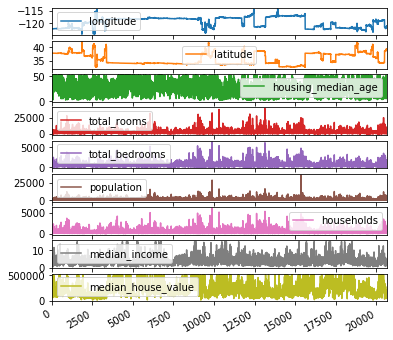

In [11]:
dataset.plot(subplots=True, figsize=(6,6))

In [0]:
Y = dataset['median_house_value']# The remainder of the columns will be used to predict Y

X = dataset.loc[:,'longitude':'median_income']

# Splits the dataset so 70% is used for training and 30% for testing and random state is set to 2003
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.3,random_state=2003)

# Converts the datasets to numpy arrays to work with our PyTorch model
x_train_np = x_train.to_numpy()
y_train_np = y_train.to_numpy()
# Convert the testing data
x_test_np = x_test.to_numpy()
y_test_np = y_test.to_numpy()

In [0]:
import torch
from torch.nn import Conv1d
from torch.nn import MaxPool1d
from torch.nn import Flatten
from torch.nn import Linear
from torch.nn.functional import relu
from torch.utils.data import DataLoader, TensorDataset

In [0]:
#cnn regressor model
class CnnRegressor(torch.nn.Module):
# Define the initialization method
  def __init__(self, batch_size, inputs, outputs):
# Initialize the superclass and store the parameters
    super(CnnRegressor, self).__init__()
    self.batch_size = batch_size
    self.inputs = inputs
    self.outputs = outputs
    # Define various layers
    # Define the input layer(input channels, output channels, kernel size)
    self.input_layer = Conv1d(inputs, batch_size, 1)
    self.max_pooling_layer = MaxPool1d(1)
    self.conv_layer = Conv1d(batch_size, 256, 1)
    self.flatten_layer = Flatten()
    self.linear_layer = Linear(256, 64)
    self.output_layer = Linear(64, outputs)
    # Define a method to feed inputs through the model
  def feed(self, input):
    input = input.reshape((self.batch_size, self.inputs, 1))
    # Get the output of various layer and run it through the ReLU activation function
    output = relu(self.input_layer(input))
    output = self.max_pooling_layer(output)
    output = relu(self.conv_layer(output))
    output = self.flatten_layer(output)
    output = self.linear_layer(output)
    
    output = self.output_layer(output)
    return output

In [15]:
# Import the SGD (stochastic gradient descent) package for our optimizer
from torch.optim import SGD
from torch.optim import Adam,Rprop
from torch.optim import Adadelta
# Import the L1Loss (mean absolute error loss) package for our performance measure
from torch.nn import L1Loss
# Import the R^2 score package from pytorch's ignite for our score measure
!pip install pytorch-ignite
from ignite.contrib.metrics.regression.r2_score import R2Score

# Define the batch size we'd like to use
batch_size = 64
# (batch size, X columns, Y columns)
model = CnnRegressor(batch_size, X.shape[1], 1)
# Set the model to use the GPU for processing
model.cuda()

CnnRegressor(
  (input_layer): Conv1d(8, 64, kernel_size=(1,), stride=(1,))
  (max_pooling_layer): MaxPool1d(kernel_size=1, stride=1, padding=0, dilation=1, ceil_mode=False)
  (conv_layer): Conv1d(64, 256, kernel_size=(1,), stride=(1,))
  (flatten_layer): Flatten()
  (linear_layer): Linear(in_features=256, out_features=64, bias=True)
  (output_layer): Linear(in_features=64, out_features=1, bias=True)
)

In [0]:
# This method will return the average L1 loss and R^2 score
def model_loss(model, dataset, train = False, optimizer = None):
  performance = L1Loss()
  score_metric = R2Score()
  avg_loss = 0
  avg_score = 0
  count = 0
  for input, output in iter(dataset):
# Get the model's predictions for the training dataset
    predictions = model.feed(input)
    # for the model's loss
    loss = performance(predictions, output)
    # for the model's R^2 score
    score_metric.update([predictions, output])
    score = score_metric.compute()

    if(train):
    # Clear any errors
      optimizer.zero_grad()
      # Compute the gradients for our optimizer
      loss.backward()
      # Use the optimizer to update the model's parameters based on the gradients
      optimizer.step()
      # Store the loss and update the counter
    avg_loss += loss.item()
    avg_score += score
    count += 1
  return avg_loss / count, avg_score / count

In [17]:
# Define the number of epochs to train for
epochs = 512
# Define the performance measure and optimizer


optimizer= Adadelta(model.parameters(), lr=1.0, rho=0.4, eps=1e-06, weight_decay=0)

#optimizer = SGD(model.parameters(), lr=1e-5)
# Convert the training set into torch variables for our model using the GPU
inputs = torch.from_numpy(x_train_np).cuda().float()
outputs = torch.from_numpy(y_train_np.reshape(y_train_np.shape[0], 1)).cuda().float()
# Create a DataLoader instance to work with our batches
tensor = TensorDataset(inputs, outputs)
loader = DataLoader(tensor, batch_size, shuffle=True, drop_last=True)
# Start the training loop
xx = 0
yy = 0
for epoch in range(epochs):
# Cycle through the batches and get the average loss
  avg_loss, avg_r2_score = model_loss(model, loader, train=True, optimizer=optimizer)
  if avg_r2_score > xx:
    xx = avg_r2_score
    yy = epochs 
# Output the average loss
print("Epoch " + str(epoch + 1) + ":\n\tLoss = " + str(avg_loss) + "\n\tR^2 Score = " + str(avg_r2_score))

Epoch 1024:
	Loss = 47384.602123038116
	R^2 Score = 0.6632692204101822


In [18]:
# Convert the testing set into torch variables for our model using the GPU
inputs = torch.from_numpy(x_test_np).cuda().float()
outputs = torch.from_numpy(y_test_np.reshape(y_test_np.shape[0], 1)).cuda().float()
# Create a DataLoader instance to work with our batches
tensor = TensorDataset(inputs, outputs)
loader = DataLoader(tensor, batch_size, shuffle=True, drop_last=True)
# Output the average performance of the model
avg_loss, avg_r2_score = model_loss(model, loader)
print("The model's L1 loss is: " + str(avg_loss))
print("The model's R^2 score is: " + str(avg_r2_score))
print("Total inference Time: %s seconds" %(time.time() - start_time))

The model's L1 loss is: 46505.84734786184
The model's R^2 score is: 0.6966701003161857
Total inference Time: 958.715151309967 seconds
